# Exercise 4: Annealing method applied to find the global minimum of a two-dimensional Thompson atomic model

**Goal:** to simulate a system composed of Coulomb charges in a two-dimensional trap (Thomson atomic model) by the classical Monte Carlo method and to use the annealing method to find the minimal energy configuration.

**Outline:**

1. Write a Metropolis Monte Carlo code to simulate a system consisting of $N$ Coulomb charges in a two-dimensional harmonic trap. The potential energy is given by

$$
E_{pot} = \sum_{i=1}^{N} \frac{1}{2}m\omega^2r_i^2 + \sum_{i<j}^{N} \frac{q^2}{|\mathbf{r}_i - \mathbf{r}_j|}
$$

Dimensionless units of length $r_0$ and energy $E_0$ can be conveniently chosen in such a way that 

$$
E_0 = \frac{1}{2}m\omega^2r_0^2 = \frac{q^2}{r_0} \quad \Rightarrow \quad r_0 = \left( \frac{2q^2}{m \omega^2}\right)^{1/3}
$$
The dimensionless variables are positions, $\tilde{r} = r/r_0$, energy $\tilde{E} = E/E_0$, temperature $\tilde{T} = k_B T/E_0$. Using these units, the potential energy reads

$$
\tilde{E}_{pot} = \sum_{i=1}^{N} \tilde{r}_i^2 + \sum_{i<j}^{N} \frac{1}{|\tilde{\mathbf{r}}_i - \tilde{\mathbf{r}}_j|} = \sum_{i=1}^{N} (x^2_i+y^2_i) + \sum_{i<j}^{N} \frac{1}{\sqrt{(x_i-x_j)^2+(y_i-y_j)^2}}
$$
.

2. Generate a random initial configuration.

3. Use Metropolis algorithm to simulate system properties at a fixed temperature $\tilde{T}$.

4. Use global moves (all particles are moved) either local moves (single particle is moved at a time), by displacing each coordinate randomly $x' = x + \xi$ where $\xi$ is drawn from a Gaussian distribution $p(\xi) = \exp(-\frac{1}{2}\frac{\xi^2}{(\Delta t)^2})$ or $\xi = (2u - 1)\Delta t$ with $0 < u < 1$ being a uniformly distributed random variable.

5. Adjust the amplitude of the displacement $\Delta t$ in such a way that the acceptance probability lies in $(0.1, 0.9)$ range

6. Verify that after an initial transient regime, potential energy converges to a certain value and fluctuates around it.

7. Implement the annealing procedure in which the temperature is lowered by a tiny fraction at each iteration (for example $T := T \times 0.999$), starting from a high temperature (large compared to the typical system energy) and ending with a low temperature.

8. Repeat the annealing procedure a number of times to verify that the optimal configuration has been found and in the case when different final configurations are realized, take the one which has the lowest energy.

9. Find and plot the optimal configurations for $N = 5; 20; 26$ charges.

10. Observe the structure of the global minimum. Is it a shell structure? Is there a nucleation of a Wigner crystal visible in the center? What is the type of lattice which is visible in the center (square, hexagonal, etc.)?

**Report:**

1. figure with a characteristic example of the energy dependence on the iteration number, show both the energy per particle and the temperature

2. snapshots of optimal configurations for $N = 5; 20; 26$ charges

3. occupations of the shells $(N_1, N_2, ...)$ as well as the energy per particle $E/N$ for $N = 5; 20; 26$ charges. Report both the obtained numbers as well as the numbers provided in literature [PRB **49**, 2667 (19974)]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

plt.rcParams['figure.figsize'] = (10, 6)

In [84]:
@njit
def compute_total_energy(N, x, y):
    """
    Computes total energy of the Thompson atomic model for N particles
    """
    trap_E = np.sum(x**2+y**2)  # Trap potential
    int_E = 0.0                 # Interaction potential
    for i in range(N-1):
        for j in range(i+1, N):
            dist = np.sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)
            int_E += 1 / dist

    return trap_E + int_E

@njit
def compute_energy_change(k, x, y, x_new_k, y_new_k, N):
    """
    Computes the delta_E for moving particle k
    """
    dE_trap = (x_new_k**2 + y_new_k**2) - (x[k]**2 + y[k]**2)
    dE_int = 0.0
    for j in range(N):
        if j != k:
            dist_old = np.sqrt((x[k]-x[j])**2 + (y[k]-y[j])**2)
            dist_new = np.sqrt((x_new_k-x[j])**2 + (y_new_k-y[j])**2)
            dE_int += (1.0/dist_new - 1.0/dist_old)
    
    return dE_trap + dE_int

@njit
def annealing_method_Thomson(N, n_step, T0, a0):
    """
    Applies Annealing method
    Inputs:
        n_step is the number of MC steps
        a0 is the amplitude of the displacement
        T temperature
    Outputs:
        energies for each MC step
        acceptance probability
    """
    # Initialize random initial configuration
    x = 2.0 * np.random.rand(N) - 1.0
    y = 2.0 * np.random.rand(N) - 1.0

    # Initial energy
    current_energy = compute_total_energy(N, x, y)

    energies = np.zeros(n_step)
    temps = np.zeros(n_step)
    acceptance_history = np.zeros(n_step)

    T = T0

    # Main MC loop
    for step in range(n_step):
        # 1. Anneling procedure (exponential cooling)
        T = 0.999 * T
        a = a0 * np.sqrt(T) # shrink it as T decreases to keep acceptance
        # Note: if acceptance rate is too low, decrease a0 (step moves are too big)
        #       if acceptance rate is too high, increase a0 (steps moves are too small)

        accepted_moves_in_step = 0

        # Sweep over particles (to move ach particle once)
        for k in range(N):
            # 2. Propose move to particle k only
            dx = a * (2.0 * np.random.rand() - 1.0)
            dy = a * (2.0 * np.random.rand() - 1.0)

            x_new_k = x[k] + dx
            y_new_k = y[k] + dy

            # 3. Compute Energy change
            delta_E = compute_energy_change(k, x, y, x_new_k, y_new_k, N)

            # 4. Metropolis algorithm
            # Accept move if energy is lower OR with probability exp(-dE / T)
            if delta_E < 0:
                accept = True
            else:
                if T > 1e-12: # Avoid division by zero for very low T
                    ratio = np.exp(- delta_E / T)
                    accept = np.random.rand() < ratio
                else:
                    accept = False
            
            if accept:
                x[k] = x_new_k
                y[k] = y_new_k
                current_energy += delta_E
                accepted_moves_in_step += 1
        

        # 5. Store data (once per step)        
        energies[step] = current_energy / N
        temps[step] = T
        acceptance_history[step] = accepted_moves_in_step / N

    return energies, temps, acceptance_history, x, y

def find_global_minimum(N, n_repeats, n_step, T0, a0):
    """
    Repeats the anneling process multiple times
    and returns the configuration with the lowest final energy.
    Returns a tuple with (energies, temps, acc_rate, x, y)
    """
    best_energy = np.inf # initial run always wins
    best_results = None 

    print(f"Searching for global minimum for N={N} with {n_repeats} runs...")

    for i in range(n_repeats):
        results = annealing_method_Thomson(N, n_step, T0, a0)
        final_energy = results[0][-1]   # get last energy

        if final_energy < best_energy:
            best_energy = final_energy
            best_results = results
    
    print(f"Best Energy found for N={N} is: {best_energy:.5f}")

    return best_results

Running simulation for N=100...
Searching for global minimum for N=100 with 10 runs...
Best Energy found for N=100 is: 26.40710


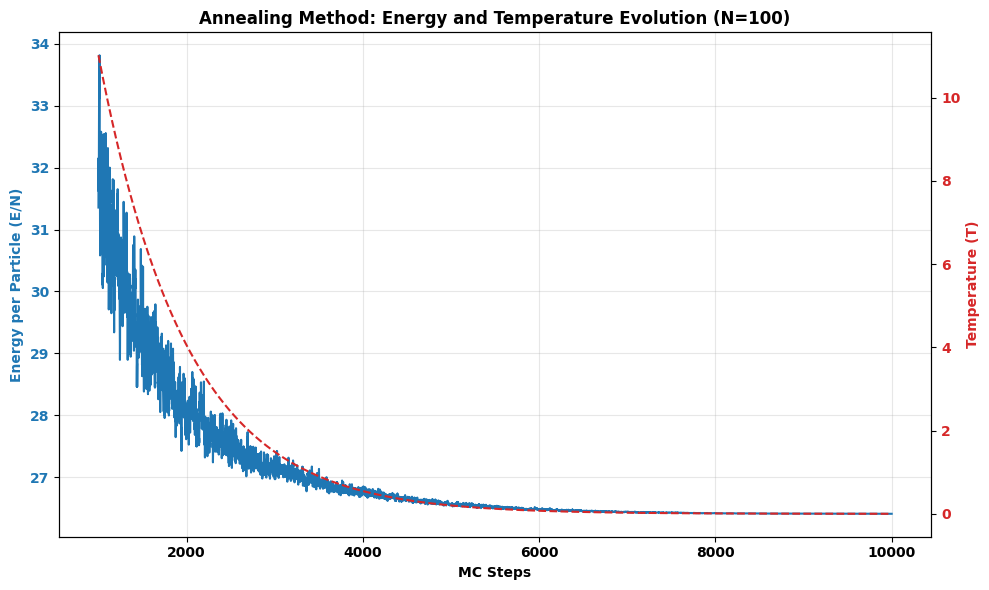

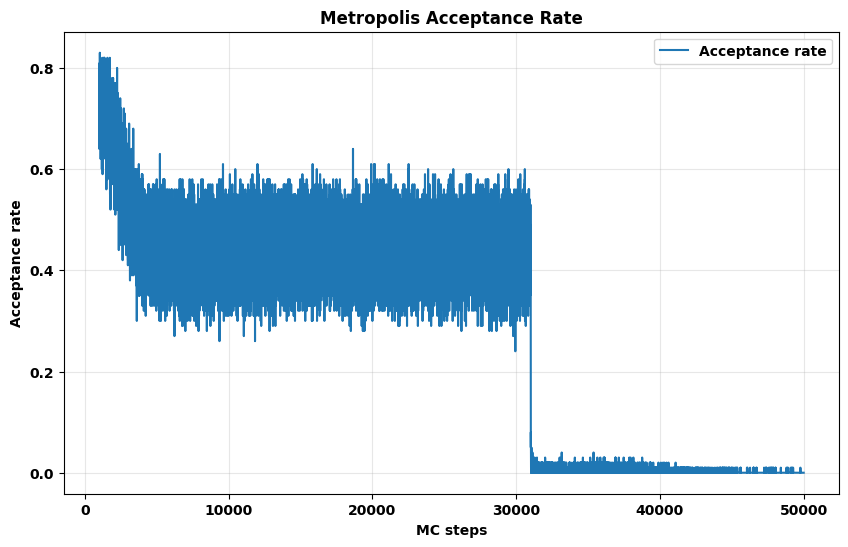

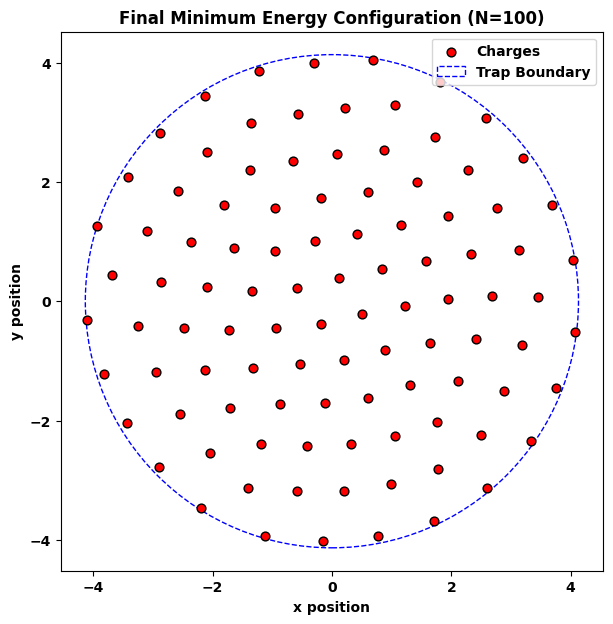

In [89]:
# --- SIMULATION for N particles ---

# Parameters
N = 100             # number of particles
n_steps = 50000     # number of Monte Carlo steps (1 step = N single moves)
n_repeats = 10      # number of independent runs to ensure we find a global min
a0 = 0.70           # step size constant such that 0.1 < acceptance_probs < 0.9
T0 = 30.0           # initial temperature

print(f"Running simulation for N={N}...")
energies, temps, acc_rate, x_final, y_final = find_global_minimum(N, n_repeats, n_steps, T0, a0)

# --- VISUALIZATION --- 
start_view = 1000
limit = 10000

steps_range1 = range(start_view, n_steps)
steps_range2 = range(start_view, limit)

# 1. Plot of Energy and Temperature Evolution
fig, ax1 = plt.subplots()

# Left axis for Energy
color_E = 'tab:blue'
ax1.set_xlabel('MC Steps')
ax1.set_ylabel('Energy per Particle (E/N)', color=color_E)
ax1.plot(steps_range2, energies[start_view:limit], color=color_E, label='Energy')
ax1.tick_params(axis='y', labelcolor=color_E)
ax1.grid(True, alpha=0.3)

# Right axis for Temperature
ax2 = ax1.twinx()  
color_T = 'tab:red'
ax2.set_ylabel('Temperature (T)', color=color_T)
ax2.plot(steps_range2, temps[start_view:limit], color=color_T, linestyle='--', label='Temperature')
ax2.tick_params(axis='y', labelcolor=color_T)

plt.title(f'Annealing Method: Energy and Temperature Evolution (N={N})')
fig.tight_layout()
plt.show()


# 2. Plot of Acceptance rate Evolution
plt.figure()
plt.plot(steps_range1, acc_rate[start_view:], label="Acceptance rate")
plt.xlabel("MC steps")
plt.ylabel("Acceptance rate")
plt.title(f"Metropolis Acceptance Rate")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# 3. Plot of Final Configuration
plt.figure(figsize=(7, 7))
plt.scatter(x_final, y_final, color='red', edgecolors='black', s=40, zorder=2, label="Charges")

# Approximate trap boundary: 
r_max = np.max(np.sqrt(x_final**2 + y_final**2))
trap = plt.Circle((0, 0), radius=r_max, color='blue', fill=False, linestyle='--', label='Trap Boundary')
plt.gca().add_patch(trap)

plt.xlabel('x position')
plt.ylabel('y position')
plt.title(f'Final Minimum Energy Configuration (N={N})')
plt.axis('equal')
plt.legend(loc='upper right')
plt.show()

Searching for global minimum for N=5 with 10 runs...
Best Energy found for N=5 is: 2.33845
Searching for global minimum for N=20 with 10 runs...
Best Energy found for N=20 is: 7.94961
Searching for global minimum for N=26 with 10 runs...
Best Energy found for N=26 is: 9.76273


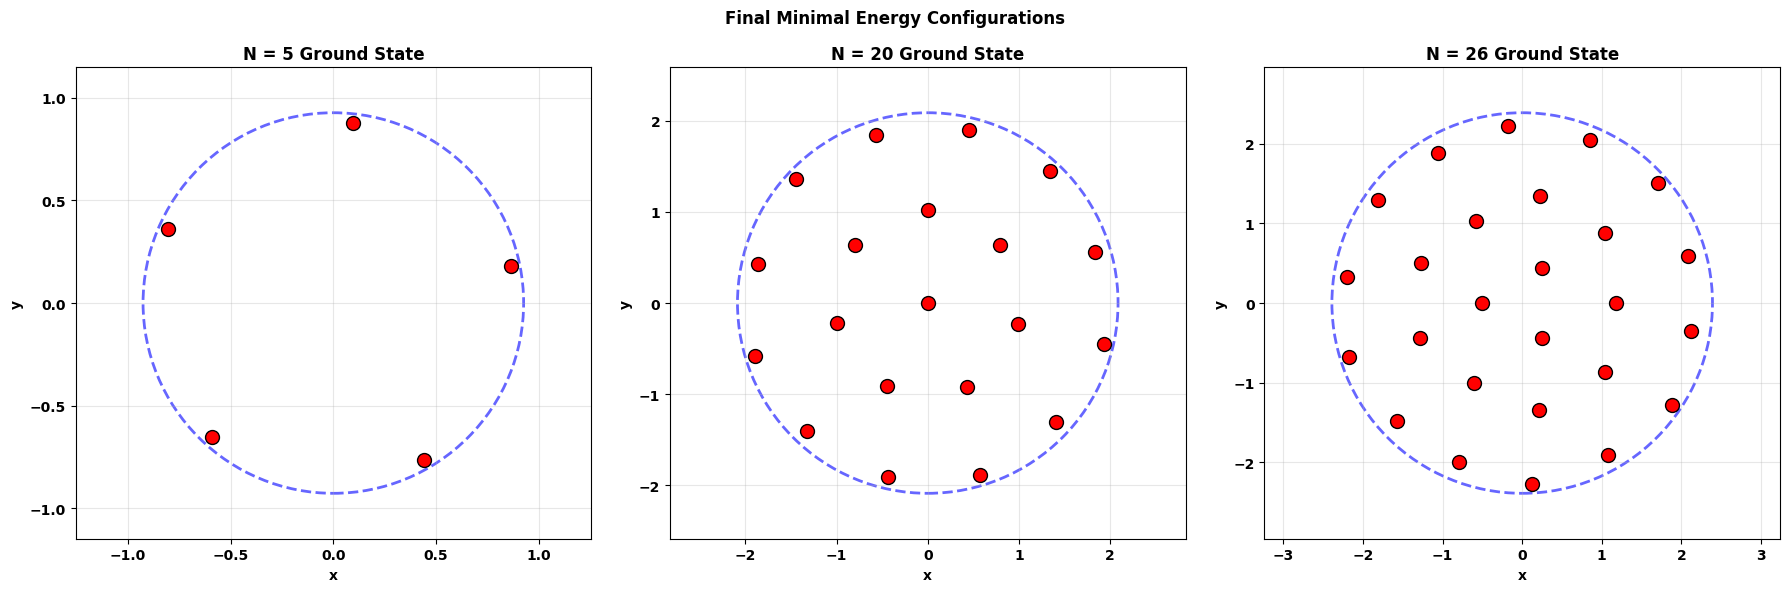

In [86]:
# --- SIMULATION for different N particles ---

# Parameters
N_list = [5, 20, 26]    # The specific cases you want to see
n_step = 100000         # MC Steps
n_repeats = 10          # to ensure global minimum
a0 = 0.70               # Constant to optimize
T0 = 20.0               # initial temp

# Store final positions for plotting
final_configs = {}

for N in N_list:
    energies, temps, acc_rate, x_final, y_final = find_global_minimum(N, n_repeats, n_steps, T0, a0)    

    final_configs[N] = (x_final, y_final)

    
# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, N in enumerate(N_list):
    ax = axes[i]
    x, y = final_configs[N]
    
    # Plot particles
    ax.scatter(x, y, color='red', edgecolors='black', s=100, zorder=2, label="Charges")
    
    # Draw approx. trap boundary
    r_max = np.max(np.sqrt(x**2 + y**2))
    trap = plt.Circle((0, 0), radius=r_max * 1.05, color='blue', fill=False, linestyle='--', linewidth=2, alpha=0.6)
    ax.add_patch(trap)
    
    ax.set_title(f'N = {N} Ground State')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.axis('equal')
    ax.grid(True, alpha=0.3)

plt.suptitle("Final Minimal Energy Configurations")
plt.tight_layout()
plt.show()

- For N = 5, we observe a pentagon with no particle in the center. This makes sense given that for small number of particles, the repulsion is strong enough to push all particles to the edge of the trap.

- For N = 20, we start seeing concentric rings: one atom in the center, 7 in the middel ring, and 12 in the outer one. This confirms the Shell structure hypothesis: adding particles make them arrange in layers to minimize the Coulomb repulsion while staying confined by the trap.
- For N = 26, we observe multiple concentric shells. Each atom is surrounded by 6 neighbors approximately at the same distance. As N increases, the so-called bulk behaviour starts manifesting: particles in the center are dense enough that they stop "knowing" about the circular boundary and start packing efficiently, producing a crystal-like structure.

On the other hand, we also compare our simulation results for the ground state energies and shell configurations with the standard values provided in *Phys. Rev. B* **49**, 2667 (1994).

| Number of Particles ($N$) | Literature Config $(N_{center}, N_{mid}, N_{outer})$ | Literature Energy ($E/N$) | Obtained Config | Obtained Energy ($E/N$) |
| :---: | :---: | :---: | :---: | :---: |
| **5** | (0, 5) | **2.3385** | (0, 5) | **2.3385** |
| **20** | (1, 7, 12) | **7.9496** | (1, 7, 12) | **7.9496** |
| **26** | (3, 9, 14) | **9.7627** | (3, 9, 14) | **9.7627** |


As we can clearly observe, the simulated and tabulated values perfectly match, proving our simulation has been carried out sucessfully.